<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0%20(%D0%B4%D0%B8%D0%B0%D0%BB%D0%BE%D0%B3%D0%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import библиотек


In [1]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np # библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Парсинг данных


In [4]:
# Открываем файл с диалогами
corpus = open('/content/drive/My Drive/Базы/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus)     # загружаем файл 
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[148]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Я - Костя Холобаев...', 'Брешете, вы не Костя...']


In [5]:
# Разбираем вопросы-ответы с проставлением тегов ответам
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list()   # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза, то сцепляем, сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) # добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) # если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [6]:
# Подключаем керасовский токенизатор и собираем словарь индексов
tokenizer = Tokenizer(oov_token='unknown')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('что', 4), ('не', 5), ('я', 6), ('а', 7), ('ты', 8), ('это', 9), ('да', 10), ('в', 11), ('нет', 12), ('как', 13), ('и', 14), ('вы', 15), ('ну', 16), ('с', 17), ('на', 18), ('же', 19), ('так', 20), ('он', 21), ('у', 22), ('кто', 23), ('где', 24), ('все', 25), ('мы', 26), ('то', 27), ('мне', 28), ('тебя', 29), ('меня', 30), ('здесь', 31), ('еще', 32), ('почему', 33), ('о', 34), ('там', 35), ('тебе', 36), ('есть', 37), ('его', 38), ('за', 39), ('куда', 40), ('вот', 41), ('ничего', 42), ('вас', 43), ('знаю', 44), ('чем', 45), ('но', 46), ('она', 47), ('они', 48), ('ли', 49), ('чего', 50)]
Размер словаря : 15105


# Создание выборки



In [7]:
#Кодируем входные данные (вопросы)
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса

# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 

Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 171   19 5710    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [8]:
#Кодируем входные данные (ответы)
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [    2   674    20    94 10559     3     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [9]:
#Раскодируем выходные данные (ответы)

tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [10]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    2   674    20    94 10559     3     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15105)
Установленная длина вопросов на выход : 13


# Нейронная сеть


In [11]:
# Первый входной слой, кодер, выходной слой
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)

# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [12]:
# Второй входной слой, декодер, выходной слой
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 

# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)

# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    3021000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3021000     input_2[0][0]                    
______________________________________________________________________________________________

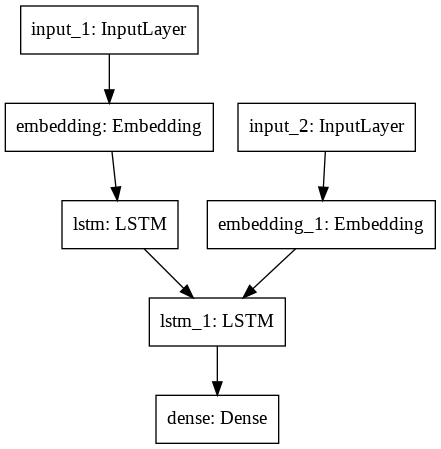

In [13]:
# Собираем тренировочную модель нейросети
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

## Обучаем модель на 10 эпохах

In [14]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=10) 

Epoch 1/10
238/238 [==============================] - 43s 37ms/step - loss: 2.5130
Epoch 2/10
238/238 [==============================] - 9s 36ms/step - loss: 1.9405
Epoch 3/10
238/238 [==============================] - 9s 36ms/step - loss: 1.9263
Epoch 4/10
238/238 [==============================] - 9s 36ms/step - loss: 1.8866
Epoch 5/10
238/238 [==============================] - 9s 36ms/step - loss: 1.8549
Epoch 6/10
238/238 [==============================] - 9s 36ms/step - loss: 1.8175
Epoch 7/10
238/238 [==============================] - 9s 36ms/step - loss: 1.7799
Epoch 8/10
238/238 [==============================] - 9s 36ms/step - loss: 1.7424
Epoch 9/10
238/238 [==============================] - 9s 36ms/step - loss: 1.6945
Epoch 10/10
238/238 [==============================] - 9s 37ms/step - loss: 1.6717


# Результат работы сети


In [15]:
# Создаем рабочую модель для вывода ответов на запросы пользователя
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы (encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [16]:
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence):      # функция принимает строку на вход (предложение с вопросом)
  CheckIndex = tokenizer.texts_to_sequences([sentence])
  return pad_sequences(CheckIndex, maxlen=maxLenQuestions , padding='post')

In [18]:
# Устанавливаем окончательные настройки и запускаем модель

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(10): # задаем количество вопросов и на каждой итерации в этом диапазоне
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))

  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие

    # В модель декодера подадим пустую последовательность со словом 'start' и состояния, предсказанные кодером по заданному вопросу
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение и вернёт нам номер индекса, под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
# и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ, сгенерированный декодером

Задайте вопрос : Как твои дела?
 да 
Задайте вопрос : Гениально. Ты философ?
 я не знаю 
Задайте вопрос : А кто знает?
 я не знаю 
Задайте вопрос : А другие ответы у тебя есть?
 да 
Задайте вопрос : Какие же?
 я не знаю 
Задайте вопрос : Сколько будет 2+2?
 двадцать командир 
Задайте вопрос : Из чего же сделаны наши мальчишки?
 не знаю 
Задайте вопрос : Из чего же сделаны наши девчонки?
 не знаю 
Задайте вопрос : Двойка тебе
 я не знаю 
Задайте вопрос : Иди учись
 ну что 
